In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from Solver import *
from functools import partial
import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet
import PlotDefault

In [2]:
beta_rek_strs = [("1", "0p3"), ("2", "0p3"), ("3", "0p3"), ("1", "0p6"), ("2", "0p6"), ("3", "0p6")]

beta_reks = [ (str_to_num(beta_rek_strs[i][0]), str_to_num(beta_rek_strs[i][1])) for i in range(len(beta_rek_strs)) ]
physics_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, yy, force = load_data(beta_rek_strs = beta_rek_strs, beta_reks = beta_reks)

# Load Model

In [3]:
TRAINING_TYPE = "direct" # indirect   indirect_res

if TRAINING_TYPE == "direct":
    trained_net = torch.load("direct.nn")
else:
    (save_folder, uki_iter) = ("indirect_NN" , 1) if TRAINING_TYPE=="direct" else ("indirect_NN_res" , 1)
 
    uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(N_iter-1) + ".dat", "rb" ) )
    trained_net = NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])




print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[  -1.5138,  -51.3196],
        [   2.1538,  -19.5970],
        [  -1.8923, -136.5389],
        [   0.2244,   -9.4505],
        [  -0.6202,   -9.9667],
        [  -9.8919,    4.6199],
        [  -2.4731,   10.8884],
        [  -8.4289,  -17.3840],
        [  -1.9792, -166.2737],
        [  -2.6043,   37.1385]], requires_grad=True)
Parameter containing:
tensor([-2.7413,  6.7542,  5.1554,  8.3043,  6.8433, 13.1191,  0.4662, 11.3819,
         5.4690,  6.7864], requires_grad=True)
Parameter containing:
tensor([[4.0401, 2.0565, 3.0697, 2.2906, 0.5681, 1.0903, 4.1241, 2.1577, 8.1816,
         9.8644]], requires_grad=True)
Parameter containing:
tensor([-13.8050], requires_grad=True)


# Direct Test

../Utility/NeuralNet.py:492: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()


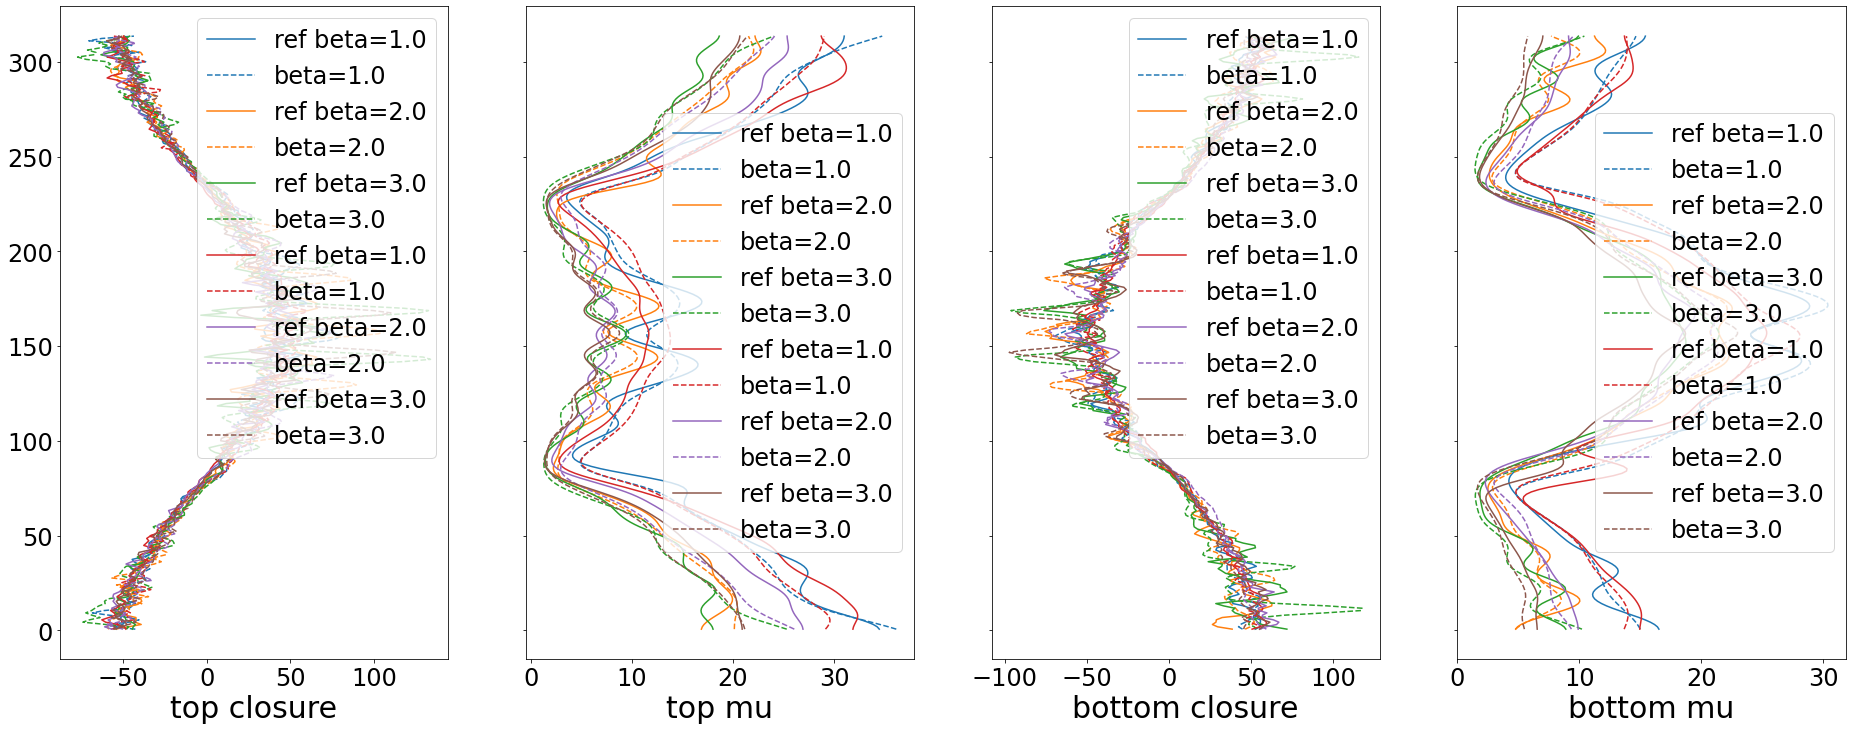

In [4]:
N_data = len(beta_reks)


x_train = torch.from_numpy(np.stack((np.abs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale)).T.astype(np.float32)) 
mu_pred = NeuralNet.net_eval(x=x_train, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=2*N_data).reshape((N_data, 2, -1))



fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,0, :], yy, "-", color="C"+str(i), label="ref beta="+str(beta_reks[i][0]))
    ax[1].plot(mu_mean_clip[i,0, :], yy, "-", color="C"+str(i), label="ref beta="+str(beta_reks[i][0]))
    ax[2].plot(closure_mean[i,1, :], yy, "-", color="C"+str(i), label="ref beta="+str(beta_reks[i][0]))
    ax[3].plot(mu_mean_clip[i,1, :], yy, "-", color="C"+str(i), label="ref beta="+str(beta_reks[i][0]))
    
    
    ax[0].plot(mu_pred[i,0, :]*dpv_mean[i,0, :], yy, "--", color="C"+str(i), label="beta="+str(beta_reks[i][0]))
    ax[1].plot(mu_pred[i,0, :], yy, "--", color="C"+str(i), label="beta="+str(beta_reks[i][0]))
    ax[2].plot(mu_pred[i,1, :]*dpv_mean[i,1, :], yy, "--", color="C"+str(i), label="beta="+str(beta_reks[i][0]))
    ax[3].plot(mu_pred[i,1, :], yy, "--", color="C"+str(i), label="beta="+str(beta_reks[i][0]))
    
    
ax[0].set_xlabel("top closure")
ax[1].set_xlabel("top mu")
ax[2].set_xlabel("bottom closure")
ax[3].set_xlabel("bottom mu")

for i in range(4):
    ax[i].legend()

fig.savefig("QG-Training-" + TRAINING_TYPE + "-Direct-Test.png")

1000 max q 319.3028871525257
2000 max q 323.2837708411571
3000 max q 326.44292068374375
4000 max q 329.079646763759
5000 max q 331.3239821928388
6000 max q 333.0002177457208
7000 max q 334.4174859435797
8000 max q 335.33819142223876
9000 max q 335.75438683126595
10000 max q 335.9769179694149
11000 max q 335.97917333911704
12000 max q 335.7861387062329
13000 max q 335.4259371763836
14000 max q 334.925536616772
15000 max q 334.3086693176701
16000 max q 333.59524131573943
17000 max q 332.8020325627713
18000 max q 331.9432767141363
19000 max q 331.0309001984342
20000 max q 330.07502006744943
21000 max q 329.084353763008
22000 max q 328.0667108000687
23000 max q 327.0296814149488
24000 max q 326.0129316167675
25000 max q 325.0047851029422
26000 max q 323.99441980325076
27000 max q 323.0242126470999
28000 max q 322.1208171749534
29000 max q 321.12366270907154
30000 max q 320.0687006900257
31000 max q 318.9863425679869
32000 max q 317.886241428013
33000 max q 316.77299384096096
34000 max q 31

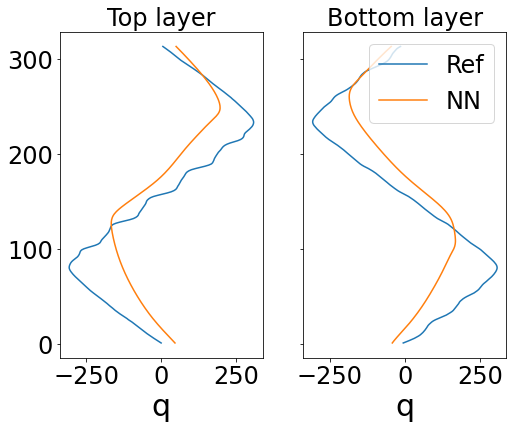

In [7]:
def Qg(params, trained_net, force):
    
#     beta  =params["beta"]
    
#     # reference
#     folder_name = "/central/groups/esm/dzhuang/pyqg_run/2layer/nx256beta" + str(beta) + "rek0p3/"
#     file_name = "nx256beta" + str(beta) + "rek0p3"
#     start, end, step = 500000, 1000000, 20000

#     flow_means_ref, _ = preprocess_data(folder_name, file_name, beta, dU, L, start, end, step)
#     mu_mean_ref, dpv_mean_ref, u_mean_ref, vor_mean_ref, q_mean_ref, psi_mean_ref, flux_mean_ref, psi_var_2_mean_ref = flow_means_ref[:8]

    
    dt = 4e-3
    save_every = 1000
    Nt = 400000 
    
    Ny = force.shape[1]
    
    # q0 = np.copy(q_mean)
    q0 = np.zeros((2, Ny))
    yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

    q0[0, :] = -params.beta*L/2 * np.sin(2*np.pi*yy/L)
    q0[1, :] =  params.beta*L/2* np.cos(2*np.pi*yy/L)
    
    beta1 = beta2 = params.beta
    nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    model = lambda q, psi, yy, res : nummodel_fft(nn_model, beta1, beta2,  q, psi, yy, res)
    yy, t_data, q_data = explicit_solve(model, force, q0, params, dt = dt, Nt = Nt, save_every = save_every)

    
    q_mean_pred = np.mean(q_data[Nt//(2*save_every):, :, :], axis=0)
    
    
    return yy, q_mean_pred, q_data 

Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd

U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
hyper_nu, hyper_order = 0.0, 2
Q = 1.0
yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)   
    
test_ind = 1
q_mean_ref = q_mean[test_ind, :, :]
# test with betas[test_ind]
params = QG_params(L=L, dU=dU, F1=F1, F2=F2, hyper_nu=hyper_nu, hyper_order=hyper_order, beta=beta_reks[test_ind][0], rek=beta_reks[test_ind][1])


yy, q_mean_pred, q_data  = Qg( params , trained_net, force)
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean_ref[0, : ], yy,   label="Ref")                                                                         
ax[0].plot(q_mean_pred[0, : ], yy, label="NN")
ax[1].plot(q_mean_ref[1, : ] , yy,   label="Ref")                                                                         
ax[1].plot(q_mean_pred[1, : ], yy, label="NN")
ax[0].set_xlabel("q")
ax[1].set_xlabel("q")

ax[0].set_title("Top layer")
ax[1].set_title("Bottom layer")

plt.legend()
fig.savefig("QG-Training-" + TRAINING_TYPE + "-Indirect-Test.png")

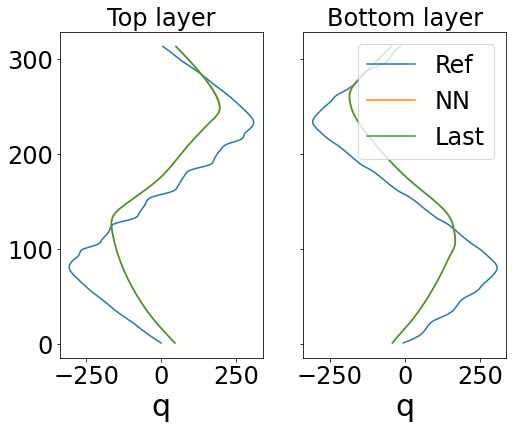

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean_ref[0, : ], yy,   label="Ref")                                                                         
ax[0].plot(q_mean_pred[0, : ], yy, label="NN")
ax[0].plot(q_data[-1, 0, :], yy, label="Last")
ax[1].plot(q_mean_ref[1, : ] , yy,   label="Ref")                                                                         
ax[1].plot(q_mean_pred[1, : ], yy, label="NN")
ax[1].plot(q_data[-1, 1, :], yy, label="Last")
ax[0].set_xlabel("q")
ax[1].set_xlabel("q")

ax[0].set_title("Top layer")
ax[1].set_title("Bottom layer")

plt.legend()
fig.savefig("QG-Training-" + TRAINING_TYPE + "-Indirect-Test.png")